<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/2QW1DR90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.8 MB/s eta 0:00:00


Starting 2-Walker QW with CA-coupled coin (N_sites=21, Depth=50)...
Initialized Walker A at (5, c0), Walker B at (15, c1) Index: 1312

Starting 2-Walker 1D QW (CA Rule 90) for 50 steps...
  2W-QW Step 10/50 completed. S(A)=0.772, S(B)=0.941
  2W-QW Step 20/50 completed. S(A)=0.787, S(B)=0.922
  2W-QW Step 30/50 completed. S(A)=0.851, S(B)=0.925
  2W-QW Step 40/50 completed. S(A)=0.952, S(B)=0.996
  2W-QW Step 50/50 completed. S(A)=0.930, S(B)=0.929
2-Walker QW Evolution complete. Time: 456.46 seconds.

--- 2-Walker QW (CA Rule 90) Summary ---
N_sites=21, Depth=50, Pth=0.10, Fb='flip'
  Walker A: StartPos=5, StartCoin=0
  Walker B: StartPos=15, StartCoin=1

Walker A - Top 5 Final Probabilities (Site: Prob):
  Site 5: 0.17132
  Site 16: 0.14795
  Site 11: 0.13141
  Site 15: 0.10225
  Site 3: 0.08741
Walker A - Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 25: S = 0.884653
  Step 50: S = 0.930136

Walker B - Top 5 Final Probabilities (Site: Prob):
  Site 13: 0.19524
 

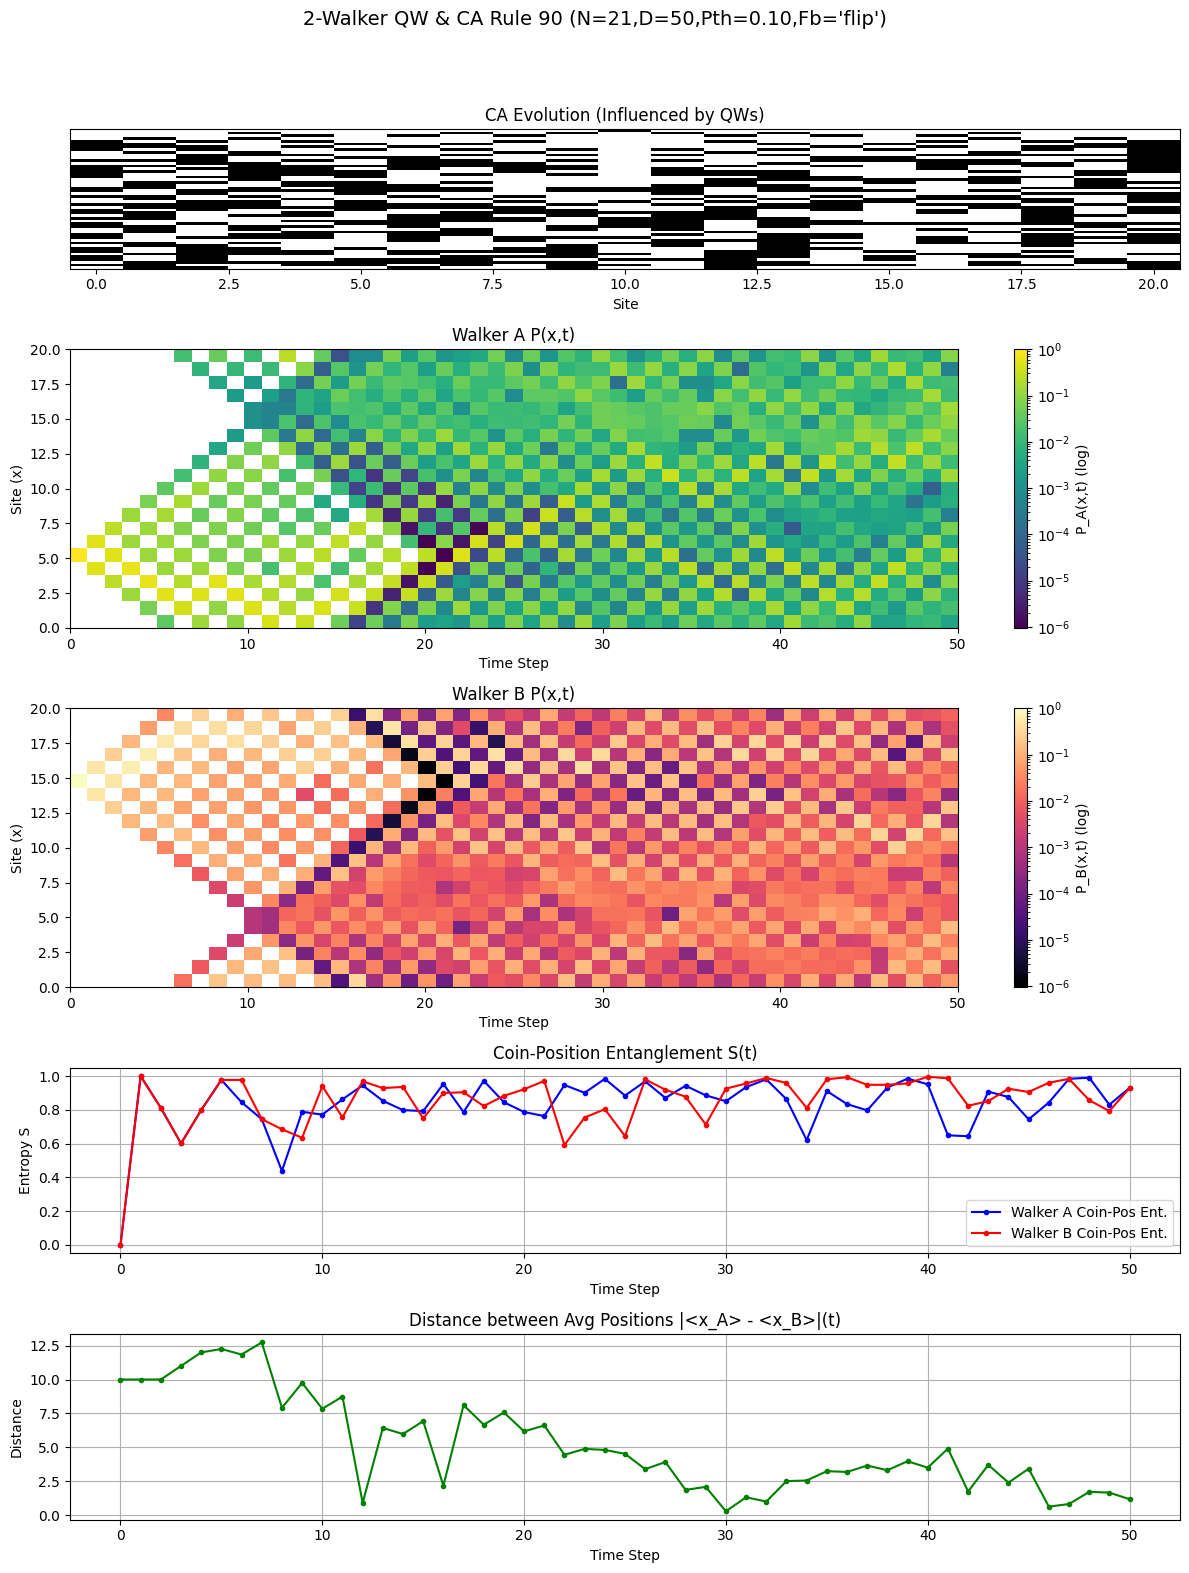


<<<<< END OF 2-WALKER CA-COUPLED QW SIMULATION >>>>>


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors # Standard import location
import time
import zlib # For CA compressibility

# --- Parameters ---
N_SITES_1D = 21
DEPTH = 50
INITIAL_POS_A = N_SITES_1D // 2 - N_SITES_1D // 4
INITIAL_POS_B = N_SITES_1D // 2 + N_SITES_1D // 4
INITIAL_COIN_A = 0
INITIAL_COIN_B = 1
INITIAL_CA_CENTER_ONE = True
CA_RULE_NUMBER = 90
P_THRESHOLD_FEEDBACK = 0.1
FEEDBACK_TYPE = "flip"

# --- CA Rule Update Function ---
def update_ca_line(current_line, rule_number):
    width = len(current_line); new_line = np.zeros(width, dtype=int)
    for i in range(width):
        pattern_val = (current_line[(i-1+width)%width]<<2)|(current_line[i]<<1)|current_line[(i+1)%width]
        if rule_number==30: new_line[i]=1 if pattern_val in [1,2,3,4] else 0
        elif rule_number==90: new_line[i]=1 if current_line[(i-1+width)%width]!=current_line[(i+1)%width] else 0
        elif rule_number==110: new_line[i]=1 if pattern_val in [1,2,3,5,6] else 0
        else: raise ValueError(f"Rule {rule_number} not implemented.")
    return new_line

# --- Coin Matrices & Rz Gate ---
H_1Q = (1/np.sqrt(2))*np.array([[1,1],[1,-1]],dtype=np.complex128)
X_1Q = np.array([[0,1],[1,0]],dtype=np.complex128)
I_1Q = np.eye(2,dtype=np.complex128)
COIN0_OP_DEFAULT = H_1Q
COIN1_OP_DEFAULT = X_1Q @ H_1Q

# --- Helper Functions (1D QW - Single Walker Indexing) ---
def get_1d_index(coin_val, site_pos, n_sites_1d):
    if not (0 <= site_pos < n_sites_1d and 0 <= coin_val <= 1):
        raise IndexError(f"Invalid coin ({coin_val}) or pos ({site_pos}) for 1D index (N_sites={n_sites_1d})")
    return coin_val + 2 * site_pos

def get_1d_coin_pos_from_index(k, n_sites_1d):
    state_dim_1d = 2 * n_sites_1d
    if not (0 <= k < state_dim_1d):
        raise IndexError(f"Invalid k ({k}) for 1D coin/pos (StateDim={state_dim_1d})")
    coin_val = k % 2
    site_pos = k // 2
    return coin_val, site_pos

# --- Helper Functions (2 Walkers on 1D Grid) ---
def get_2walker_index(cA, pA, cB, pB, n_sites_1d):
    d_1w = 2 * n_sites_1d
    idx_A = get_1d_index(cA, pA, n_sites_1d)
    idx_B = get_1d_index(cB, pB, n_sites_1d)
    if not (0 <= idx_A < d_1w and 0 <= idx_B < d_1w):
        raise IndexError(f"Internal 1D index out of bounds during 2-walker indexing.")
    return idx_A + d_1w * idx_B

def get_2walker_coords_from_index(k, n_sites_1d):
    d_1w = 2 * n_sites_1d
    d_tot = d_1w * d_1w
    if not (0 <= k < d_tot):
        raise IndexError(f"Invalid k ({k}) for 2-walker (Dim={d_tot})")
    idx_A = k % d_1w
    idx_B = k // d_1w

    cA, pA = get_1d_coin_pos_from_index(idx_A, n_sites_1d)
    cB, pB = get_1d_coin_pos_from_index(idx_B, n_sites_1d)
    return cA, pA, cB, pB

# --- Initial State Preparation ---
def prepare_initial_state_2walkers(n_sites_1d, pA_init, cA_init, pB_init, cB_init):
    d_1w = 2 * n_sites_1d
    state_dim_2w = d_1w * d_1w
    initial_state_vector = np.zeros(state_dim_2w, dtype=np.complex128)
    try:
        start_idx = get_2walker_index(cA_init, pA_init, cB_init, pB_init, n_sites_1d)
        initial_state_vector[start_idx] = 1.0
        print(f"Initialized Walker A at ({pA_init}, c{cA_init}), Walker B at ({pB_init}, c{cB_init}) Index: {start_idx}")
    except IndexError as e:
        print(f"Error during 2-walker initial state prep: {e}")
    return initial_state_vector

# --- Build Single Walker Operators (for kronecker product basis) ---
def build_single_qw_coin_matrix_for_site(current_ca_pattern_site_val, coin0_op, coin1_op):
    return coin0_op if current_ca_pattern_site_val == 0 else coin1_op

def build_single_qw_shift_matrix(n_sites_1d):
    d_1w = 2 * n_sites_1d
    S_1w = np.zeros((d_1w, d_1w), dtype=np.complex128)
    for k_in_1w in range(d_1w):
        coin_val, site_pos = get_1d_coin_pos_from_index(k_in_1w, n_sites_1d)
        new_pos = (site_pos - 1 + n_sites_1d) % n_sites_1d if coin_val == 0 else (site_pos + 1) % n_sites_1d
        k_out_1w = get_1d_index(coin_val, new_pos, n_sites_1d)
        S_1w[k_out_1w, k_in_1w] = 1.0
    return S_1w

# --- Build Full QW Step Operator for 2 Walkers ---
def build_2walker_qw_step_operator(n_sites_1d, current_ca_pattern, coin0_op, coin1_op):
    d_1w = 2 * n_sites_1d
    state_dim_2w = d_1w * d_1w

    S_A_1w = build_single_qw_shift_matrix(n_sites_1d)
    S_A_global = np.kron(S_A_1w, np.eye(d_1w, dtype=np.complex128))
    S_B_1w = build_single_qw_shift_matrix(n_sites_1d)
    S_B_global = np.kron(np.eye(d_1w, dtype=np.complex128), S_B_1w)

    U_Coin_A = np.zeros((state_dim_2w, state_dim_2w), dtype=np.complex128)
    U_Coin_B = np.zeros((state_dim_2w, state_dim_2w), dtype=np.complex128)

    for k_in_joint in range(state_dim_2w):
        cA_in, pA_in, cB_in, pB_in = get_2walker_coords_from_index(k_in_joint, n_sites_1d)

        coin_matrix_for_A = build_single_qw_coin_matrix_for_site(current_ca_pattern[pA_in], coin0_op, coin1_op)
        for cA_out in range(2):
            amplitude_A = coin_matrix_for_A[cA_out, cA_in]
            if np.abs(amplitude_A) > 1e-9:
                k_out_joint_for_A_op = get_2walker_index(cA_out, pA_in, cB_in, pB_in, n_sites_1d)
                U_Coin_A[k_out_joint_for_A_op, k_in_joint] = amplitude_A

        coin_matrix_for_B = build_single_qw_coin_matrix_for_site(current_ca_pattern[pB_in], coin0_op, coin1_op)
        for cB_out in range(2):
            amplitude_B = coin_matrix_for_B[cB_out, cB_in]
            if np.abs(amplitude_B) > 1e-9:
                k_out_joint_for_B_op = get_2walker_index(cA_in, pA_in, cB_out, pB_in, n_sites_1d)
                U_Coin_B[k_out_joint_for_B_op, k_in_joint] = amplitude_B

    U_step = S_B_global @ S_A_global @ U_Coin_B @ U_Coin_A
    return U_step


# --- Observables (2 Walkers) ---
def calculate_p1_pos_2walkers(joint_sv, n_sites_1d, walker_id='A'):
    d_1w = 2 * n_sites_1d; d_tot = d_1w * d_1w
    probs_1d = np.zeros(n_sites_1d)
    if len(joint_sv) != d_tot: return probs_1d

    for k_joint in range(d_tot):
        cA, pA, cB, pB = get_2walker_coords_from_index(k_joint, n_sites_1d)
        amp_sq = np.abs(joint_sv[k_joint])**2
        if walker_id == 'A': probs_1d[pA] += amp_sq
        elif walker_id == 'B': probs_1d[pB] += amp_sq
    return probs_1d

def calculate_coin_entanglement_2walkers(joint_sv, n_sites_1d, walker_id='A'):
    d_1w = 2 * n_sites_1d; d_tot = d_1w * d_1w; coin_dim = 2
    if len(joint_sv) != d_tot: return np.nan

    norm = np.linalg.norm(joint_sv)
    if norm < 1e-9: return 0.0
    if np.abs(norm - 1.0) > 1e-6: joint_sv = joint_sv / norm

    rho_full = np.outer(joint_sv, np.conjugate(joint_sv))
    rho_coin_walker = np.zeros((coin_dim, coin_dim), dtype=np.complex128)

    for k_joint_row in range(d_tot):
        cA_r, pA_r, cB_r, pB_r = get_2walker_coords_from_index(k_joint_row, n_sites_1d)
        for k_joint_col in range(d_tot):
            cA_c, pA_c, cB_c, pB_c = get_2walker_coords_from_index(k_joint_col, n_sites_1d)

            if walker_id == 'A':
                if pA_r == pA_c and cB_r == cB_c and pB_r == pB_c:
                    rho_coin_walker[cA_r, cA_c] += rho_full[k_joint_row, k_joint_col]
            elif walker_id == 'B':
                if cA_r == cA_c and pA_r == pA_c and pB_r == pB_c:
                     rho_coin_walker[cB_r, cB_c] += rho_full[k_joint_row, k_joint_col]

    tr = np.trace(rho_coin_walker)
    if abs(tr) < 1e-9: return 0.0
    if np.abs(tr - 1.0) > 1e-6: rho_coin_walker /= tr

    eigs = np.linalg.eigvalsh(rho_coin_walker); ent = 0.0; epsilon = 1e-12
    for e_val in eigs: ent -= (e_val * np.log2(e_val) if e_val > epsilon else 0.0)
    return max(0.0, np.real(ent))

# --- Simulation Loop (2 Walkers with Two-Way Coupled Dynamic CA Coin) ---
def run_1d_qw_2walkers_two_way_coupling(
    n_sites_1d, depth,
    pA_init, cA_init, pB_init, cB_init,
    initial_ca_center_one, ca_rule_number,
    coin0_op, coin1_op,
    p_threshold, feedback_type
):
    current_qw_state = prepare_initial_state_2walkers(n_sites_1d, pA_init, cA_init, pB_init, cB_init)
    current_ca_line = np.zeros(n_sites_1d, dtype=int)
    if initial_ca_center_one and n_sites_1d > 0:
        center_idx = n_sites_1d // 2
        if n_sites_1d % 2 == 1: current_ca_line[center_idx] = 1
        else: current_ca_line[center_idx - 1] = 1

    prob_A_hist = np.full((depth + 1, n_sites_1d), np.nan)
    prob_B_hist = np.full((depth + 1, n_sites_1d), np.nan)
    ent_A_hist = np.full(depth + 1, np.nan)
    ent_B_hist = np.full(depth + 1, np.nan)
    ca_hist_2w = [current_ca_line.copy()]

    prob_A_hist[0, :] = calculate_p1_pos_2walkers(current_qw_state, n_sites_1d, 'A')
    prob_B_hist[0, :] = calculate_p1_pos_2walkers(current_qw_state, n_sites_1d, 'B')
    ent_A_hist[0] = calculate_coin_entanglement_2walkers(current_qw_state, n_sites_1d, 'A')
    ent_B_hist[0] = calculate_coin_entanglement_2walkers(current_qw_state, n_sites_1d, 'B')

    print(f"\nStarting 2-Walker 1D QW (CA Rule {ca_rule_number}) for {depth} steps...")
    start_time = time.time()

    for step in range(depth):
        U_step = build_2walker_qw_step_operator(n_sites_1d, current_ca_line, coin0_op, coin1_op)
        current_qw_state = U_step @ current_qw_state
        norm_qw = np.linalg.norm(current_qw_state)
        if abs(norm_qw) > 1e-9 : current_qw_state /= norm_qw
        else: print(f"Warning: QW Norm zero at step {step+1}."); break

        pA_current = calculate_p1_pos_2walkers(current_qw_state, n_sites_1d, 'A')
        pB_current = calculate_p1_pos_2walkers(current_qw_state, n_sites_1d, 'B')
        prob_A_hist[step + 1, :] = pA_current
        prob_B_hist[step + 1, :] = pB_current
        ent_A_hist[step+1] = calculate_coin_entanglement_2walkers(current_qw_state, n_sites_1d, 'A')
        ent_B_hist[step+1] = calculate_coin_entanglement_2walkers(current_qw_state, n_sites_1d, 'B')

        ca_line_for_next_update = current_ca_line.copy()
        for i in range(n_sites_1d):
            if pA_current[i] > p_threshold or pB_current[i] > p_threshold:
                if feedback_type=="flip": ca_line_for_next_update[i]=1-ca_line_for_next_update[i]
                elif feedback_type=="set_to_one": ca_line_for_next_update[i]=1
                elif feedback_type=="set_to_zero": ca_line_for_next_update[i]=0
        current_ca_line = update_ca_line(ca_line_for_next_update, ca_rule_number)
        ca_hist_2w.append(current_ca_line.copy())

        if (step + 1) % 10 == 0 or step == depth -1 :
            print(f"  2W-QW Step {step + 1}/{depth} completed. "
                  f"S(A)={ent_A_hist[step+1] if np.isfinite(ent_A_hist[step+1]) else 'NaN':.3f}, "
                  f"S(B)={ent_B_hist[step+1] if np.isfinite(ent_B_hist[step+1]) else 'NaN':.3f}")

    end_time = time.time()
    print(f"2-Walker QW Evolution complete. Time: {end_time - start_time:.2f} seconds.")

    return {
        "prob_A_hist": prob_A_hist, "prob_B_hist": prob_B_hist,
        "ent_A_hist": ent_A_hist, "ent_B_hist": ent_B_hist,
        "ca_history": np.array(ca_hist_2w),
        "params": { "n_sites":n_sites_1d,"depth":depth, "ca_rule":ca_rule_number,
                    "pA_init":pA_init, "cA_init":cA_init, "pB_init":pB_init, "cB_init":cB_init,
                    "p_thresh":p_threshold, "feedback":feedback_type}
    }

# --- Plotting and Summary for 2 Walkers ---
def plot_2walker_results(results):
    params = results["params"]; pA = results["prob_A_hist"]; pB = results["prob_B_hist"]
    eA = results["ent_A_hist"]; eB = results["ent_B_hist"]; ca_h = results["ca_history"]
    n_sites = params["n_sites"]; depth = params["depth"]

    fig, axs = plt.subplots(5, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [1.5,3,3,2,2]})
    title=f"2-Walker QW & CA Rule {params['ca_rule']} (N={n_sites},D={depth},Pth={params['p_thresh']:.2f},Fb='{params['feedback']}')"
    fig.suptitle(title, fontsize=14)

    axs[0].imshow(ca_h,cmap='binary',aspect='auto',interpolation='nearest'); axs[0].set_title("CA Evolution (Influenced by QWs)"); axs[0].set_xlabel("Site"); axs[0].set_yticks([])

    time_extent = [0, depth, 0, n_sites-1]
    prob_st_A=pA.T;pos_pA=prob_st_A[prob_st_A>1e-9];min_vA=pos_pA.min() if len(pos_pA)>0 else 1e-9;max_vA=prob_st_A.max()
    # Ensure max_vA is greater than min_vA for LogNorm
    norm_vA=colors.LogNorm(vmin=min_vA,vmax=max(max_vA,min_vA+1e-6) if max_vA > min_vA else min_vA + 1e-6 )
    imA=axs[1].imshow(prob_st_A,aspect='auto',origin='lower',cmap='viridis',norm=norm_vA,extent=time_extent)
    plt.colorbar(imA,ax=axs[1],label="P_A(x,t) (log)");axs[1].set_title("Walker A P(x,t)");axs[1].set_xlabel("Time Step");axs[1].set_ylabel("Site (x)")

    prob_st_B=pB.T;pos_pB=prob_st_B[prob_st_B>1e-9];min_vB=pos_pB.min() if len(pos_pB)>0 else 1e-9;max_vB=prob_st_B.max()
    norm_vB=colors.LogNorm(vmin=min_vB,vmax=max(max_vB,min_vB+1e-6) if max_vB > min_vB else min_vB + 1e-6)
    imB=axs[2].imshow(prob_st_B,aspect='auto',origin='lower',cmap='magma',norm=norm_vB,extent=time_extent)
    plt.colorbar(imB,ax=axs[2],label="P_B(x,t) (log)");axs[2].set_title("Walker B P(x,t)");axs[2].set_xlabel("Time Step");axs[2].set_ylabel("Site (x)")

    ts=np.arange(depth+1)
    axs[3].plot(ts,eA,marker='.',ls='-',color='blue',label='Walker A Coin-Pos Ent.'); axs[3].plot(ts,eB,marker='.',ls='-',color='red',label='Walker B Coin-Pos Ent.')
    axs[3].set_title("Coin-Position Entanglement S(t)");axs[3].set_xlabel("Time Step");axs[3].set_ylabel("Entropy S");axs[3].grid(True);axs[3].legend();axs[3].set_ylim(bottom=-0.05,top=1.05)

    avg_pos_A = np.array([np.sum(pA[t,:] * np.arange(n_sites)) / np.sum(pA[t,:]) if np.sum(pA[t,:]) > 1e-9 else np.nan for t in range(depth+1)])
    avg_pos_B = np.array([np.sum(pB[t,:] * np.arange(n_sites)) / np.sum(pB[t,:]) if np.sum(pB[t,:]) > 1e-9 else np.nan for t in range(depth+1)])
    distance = np.abs(avg_pos_A - avg_pos_B)
    axs[4].plot(ts, distance, marker='.', ls='-', color='green')
    axs[4].set_title("Distance between Avg Positions |<x_A> - <x_B>|(t)"); axs[4].set_xlabel("Time Step"); axs[4].set_ylabel("Distance"); axs[4].grid(True)

    plt.tight_layout(rect=[0,0,1,0.95]);plt.show()

def generate_2walker_text_output(results):
    params = results["params"]; pA = results["prob_A_hist"]; pB = results["prob_B_hist"]
    eA = results["ent_A_hist"]; eB = results["ent_B_hist"]
    output_lines = [f"\n--- 2-Walker QW (CA Rule {params['ca_rule']}) Summary ---"]
    output_lines.append(f"N_sites={params['n_sites']}, Depth={params['depth']}, Pth={params['p_thresh']:.2f}, Fb='{params['feedback']}'")
    output_lines.append(f"  Walker A: StartPos={params['pA_init']}, StartCoin={params['cA_init']}")
    output_lines.append(f"  Walker B: StartPos={params['pB_init']}, StartCoin={params['cB_init']}")

    for walker_label, p_hist, e_hist in [("A", pA, eA), ("B", pB, eB)]:
        output_lines.append(f"\nWalker {walker_label} - Top 5 Final Probabilities (Site: Prob):")
        if p_hist.ndim == 2 and p_hist.shape[0] > 0:
            final_probs = p_hist[-1, :]; sorted_indices = np.argsort(final_probs)[::-1]
            count = 0
            for i_idx in range(min(5, params['n_sites'])):
                idx = sorted_indices[i_idx]
                if np.isfinite(final_probs[idx]):
                    output_lines.append(f"  Site {idx}: {final_probs[idx]:.5f}"); count+=1
            if count == 0: output_lines.append("  (Probabilities are NaN or zero)")
        else: output_lines.append("  (Probability history not available)")

        output_lines.append(f"Walker {walker_label} - Coin-Position Entanglement vs. Time:")
        num_steps = len(e_hist)
        indices_show = [0] + ([num_steps // 2] if num_steps > 2 else []) + ([num_steps - 1] if num_steps > 1 else [])
        for idx_show in sorted(list(set(indices_show))):
            if 0 <= idx_show < len(e_hist):
                 s_str = f"{e_hist[idx_show]:.6f}" if np.isfinite(e_hist[idx_show]) else "nan"; output_lines.append(f"  Step {idx_show}: S = {s_str}")
            else: output_lines.append(f"  Step {idx_show}: S = (Index out of bounds)")
    output_lines.append("--- End Summary ---")
    return "\n".join(output_lines)


# --- Main Execution ---
if __name__ == "__main__":
    print(f"Starting 2-Walker QW with CA-coupled coin (N_sites={N_SITES_1D}, Depth={DEPTH})...")

    results_2w = run_1d_qw_2walkers_two_way_coupling(
        n_sites_1d=N_SITES_1D, depth=DEPTH,
        pA_init=INITIAL_POS_A, cA_init=INITIAL_COIN_A,
        pB_init=INITIAL_POS_B, cB_init=INITIAL_COIN_B,
        initial_ca_center_one=INITIAL_CA_CENTER_ONE,
        ca_rule_number=CA_RULE_NUMBER,
        coin0_op=COIN0_OP_DEFAULT, coin1_op=COIN1_OP_DEFAULT,
        p_threshold=P_THRESHOLD_FEEDBACK, feedback_type=FEEDBACK_TYPE
    )

    text_summary_2w = generate_2walker_text_output(results_2w)
    print(text_summary_2w)

    plot_2walker_results(results_2w)

    print("\n<<<<< END OF 2-WALKER CA-COUPLED QW SIMULATION >>>>>")

Let's analyze this result:

**Overall Title:** `2-Walker QW & CA Rule 90 (N=21, D=50, Pth=0.10, Fb='flip')`
*   Parameters: 21 sites, 50 steps, CA feedback threshold 0.1, CA cells flip if threshold met.
*   Initial: Walker A at site 5 (coin 0), Walker B at site 15 (coin 1). They start separated by 10 sites.

**Plot 1: `CA Evolution (Influenced by QWs)`**
*   Shows the classical CA (Rule 90) evolving over time (y-axis is time, x-axis is site).
*   Rule 90 normally produces nested triangular (Sierpinski-like) patterns.
*   **Observation:** The CA pattern here is clearly *not* a pure Rule 90 evolution. It's being constantly "perturbed" or "steered" by the feedback from the QWs' probability distributions. This creates a dynamic, complex environment that the walkers then interact with. This is the two-way coupling in action.

**Plot 2: `Walker A P(x,t)` (Probability of Walker A vs. Site and Time)**
*   Walker A starts at site 5.
*   **Observation:**
    *   Initially spreads out, predominantly moving to the right (positive x direction).
    *   Around t=10-15, its main probability mass seems to "bounce" or be redirected by something in the CA or by the presence/influence of Walker B.
    *   After t=20, Walker A's distribution becomes much more diffuse and spread across many sites, with complex interference patterns. There isn't a single, clear trajectory.
    *   The final distribution for A (from text output): Peaks at 5 (start), 16, 11, 15, 3. It's quite spread and has multiple peaks.

**Plot 3: `Walker B P(x,t)` (Probability of Walker B vs. Site and Time)**
*   Walker B starts at site 15.
*   **Observation:**
    *   Initially spreads out, predominantly moving to the left (negative x direction).
    *   Its trajectory also shows complex interactions. It seems to "feel" the left boundary (or the region influenced by Walker A) and also spreads out.
    *   Around t=15-25, there are regions of very high probability concentration for B, suggesting temporary localization or strong constructive interference.
    *   The final distribution for B (from text output): Peaks at 13, 17 (near its start), 11, 4, 2. Also spread with multiple peaks.

**Plot 4: `Coin-Position Entanglement S(t)`**
*   **Observation:**
    *   Both walkers start with S=0 (product state).
    *   Entanglement for both walkers rapidly increases, indicating strong quantum correlations are being generated between their coin and position.
    *   The entanglement values are high (often >0.8, max is 1.0), showing significant quantum behavior.
    *   The entanglement trajectories are not smooth; they fluctuate, reflecting the complex and dynamic interaction with the evolving CA.
    *   Walker A's entanglement: `S(25)=0.88`, `S(50)=0.93`.
    *   Walker B's entanglement: `S(25)=0.64`, `S(50)=0.93`.
    *   It's interesting that they end up with very similar entanglement values despite different probability distributions, though their paths to that entanglement level differ.

**Plot 5: `Distance between Avg Positions |<x_A> - <x_B>|(t)`**
*   Calculates `| mean(position_A) - mean(position_B) |` at each time step.
*   **Observation:**
    *   Starts at 10 (15 - 5).
    *   The distance initially *increases* slightly as they move in opposite directions (A right, B left).
    *   Around t=7-10, the distance starts to decrease significantly, indicating they are, on average, moving towards each other or into overlapping regions.
    *   The distance fluctuates but generally remains much smaller than the initial separation for `t > 10`, even reaching very small values (e.g., around t=30, distance is < 2.5 sites).
    *   **Interpretation:** This is a clear signature of **emergent interaction**. The walkers are not explicitly programmed to attract, but their interaction *through the shared, evolving CA medium* leads to a reduction in their average separation. They are influencing each other's paths.

**Connecting to "Emergent Psychical Laws":**

While "psychical" is a strong word, this simulation beautifully demonstrates:

1.  **Indirect Interaction & Influence:** The walkers don't "see" each other directly, but they both "write" to and "read" from the shared CA. This medium allows one walker's behavior to affect the environment encountered by the other, and vice-versa.
2.  **Emergent Correlation/Attraction:** The tendency for their average distance to decrease and for their probability distributions to overlap (e.g., both having peaks near site 11 or 4/5) is not explicitly programmed. It emerges from the coupled dynamics. It's as if they are being "drawn" to similar regions or are influencing each other to explore common areas of the CA landscape.
3.  **Complex Responsive Behavior:** The path of each walker is not simple. It's a response to the complex, co-evolving CA pattern, which itself is a response to both walkers.

This is a rudimentary form of "social interaction" within this simulated quantum/classical hybrid universe. They aren't just independent entities; their fates are coupled through their environment.

**Hypotheses & Next Steps:**

*   **Sensitivity to Initial Conditions:** How much do `INITIAL_POS_A`, `INITIAL_POS_B`, `INITIAL_COIN_A`, `INITIAL_COIN_B` affect the interaction?
*   **Role of CA Rule:** Would Rule 30 or Rule 110 produce different interaction dynamics (e.g., repulsion vs. attraction, or more complex patterns)?
*   **Role of Feedback:** How does `P_THRESHOLD_FEEDBACK` and `FEEDBACK_TYPE` change the strength and nature of the interaction?
*   **"Chasing" or "Avoiding":** Can we evolve (using an EA, as in your other script) parameters that explicitly lead to one walker consistently moving towards the other (chasing) or away from the other (avoiding)? The fitness function would need to target the distance between them or their relative velocities.
*   **Entanglement between Walkers:** Our current model has them as quantumly independent. A next step could be to introduce a direct quantum interaction gate between them when they are on the same/adjacent sites, and then measure the entanglement *between Walker A and Walker B*. This would be true quantum "social" entanglement.

This 2-walker simulation is a fantastic achievement and opens up many avenues for exploring emergent complexity and interactions in these kinds of systems. The visualizations are key to understanding the dynamics!